통계적 사고 (2판) 연습문제 ([thinkstats2.com](thinkstats2.com), [think-stat.xwmooc.org](http://think-stat.xwmooc.org))<br>
Allen Downey / 이광춘(xwMOOC)

## 연습문제 13.1

NSFG 주기 6과 7에서, cmdivorcx 변수는 응답자의 만약 적용되다면 년도-월(century-month)로 부호화된 첫 혼인에 대한 이혼 날짜 정보를 담고 있다.
이혼으로 끝나는 결혼기간과 지금까지 지속되는 혼인 기간을 계산하시오. 결혼기간에 대한 위험함수와 생존함수를 추정하시오.

표집 가중치를 고려해서 재표집을 사용하고, 표집오차를 시각화하는데 재표집으로 나온 표본에서 데이터를 도식화하시오.

응답자를 10년주기 출생으로 집단화하고, 가능하면 첫번째 혼인 연령으로 나누는 것을 고려한다.

5 535
6 4154
7 3781
8 1184
9 6
5 524
6 4115
7 3826
8 1189
9 6
5 492
6 4241
7 3747
8 1172
9 8
5 499
6 4191
7 3790
8 1169
9 11
5 498
6 4159
7 3785
8 1208
9 10
5 466
6 4195
7 3811
8 1180
9 8
5 511
6 4187
7 3811
8 1148
9 3
5 504
6 4264
7 3752
8 1132
9 8
5 504
6 4214
7 3739
8 1192
9 11
5 526
6 4169
7 3761
8 1197
9 7
5 489
6 4203
7 3780
8 1181
9 7
5 535
6 4225
7 3715
8 1175
9 10
5 491
6 4221
7 3760
8 1181
9 7
5 524
6 4214
7 3753
8 1161
9 8
5 541
6 4163
7 3797
8 1151
9 8
5 535
6 4191
7 3822
8 1099
9 13
5 516
6 4151
7 3824
8 1154
9 15
5 533
6 3993
7 3938
8 1186
9 10
5 498
6 4183
7 3801
8 1172
9 6
5 519
6 4178
7 3783
8 1175
9 5
5 497
6 4166
7 3851
8 1138
9 8
5 515
6 4168
7 3779
8 1192
9 6
5 459
6 4223
7 3840
8 1132
9 6
5 482
6 4132
7 3868
8 1172
9 6
5 518
6 4200
7 3773
8 1163
9 6
5 537
6 4171
7 3773
8 1169
9 10
5 542
6 4204
7 3727
8 1175
9 12
5 482
6 4177
7 3777
8 1214
9 10
5 524
6 4127
7 3869
8 1131
9 9
5 509
6 4135
7 3828
8 1182
9 6
5 544
6 4161
7 3773
8 1170
9 12
5 516
6 4206
7 3753
8 1179
9

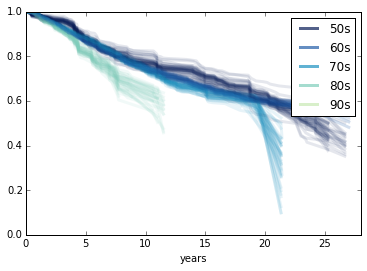

In [3]:
%matplotlib inline
from __future__ import print_function

import pandas
import numpy as np

import thinkplot
import thinkstats2
import survival


def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pandas.to_datetime('1899-12-15')
    dates = [month0 + pandas.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pandas.DatetimeIndex(dates).year - 1900) // 10


def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])


def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames    
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])


def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        print(name, len(group))
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)


def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration
    ongoing = resp[resp.notdivorced == 1].durationsofar

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf


def main():
    resp6 = survival.ReadFemResp2002()
    CleanData(resp6)
    married6 = resp6[resp6.evrmarry==1]

    resp7 = survival.ReadFemResp2010()
    CleanData(resp7)
    married7 = resp7[resp7.evrmarry==1]

    ResampleDivorceCurveByDecade([married6, married7])


if __name__ == '__main__':
    main()